In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

# Main Pandas Commands

### Overview of the data

In [39]:
housing = pd.read_csv('data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [40]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [41]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [42]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


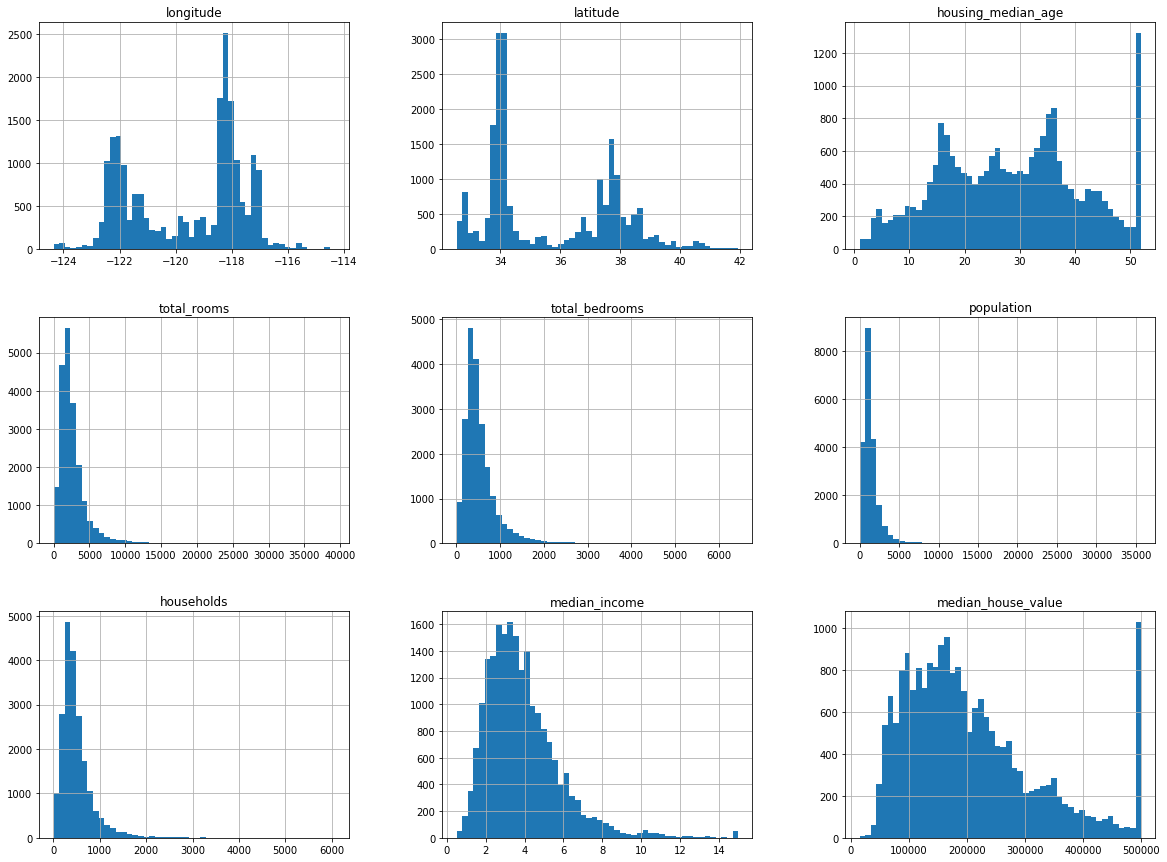

In [43]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Create an attribute from continuous data

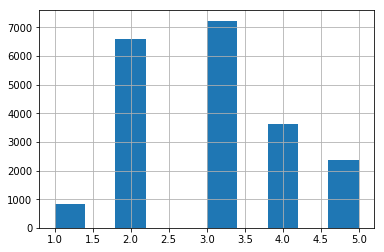

In [44]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()
plt.show()

# Building the train/test datasets

### Classic sampling

In [45]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(f"Number of samples in the train set: {len(train_set)}")
print(f"Number of samples in the test set: {len(test_set)}")

Number of samples in the train set: 16512
Number of samples in the test set: 4128


In [46]:
print(test_set["income_cat"].value_counts() / len(test_set))

3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64


### Stratified sampling (according to one feature)

In [47]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


### Comparison with dataframe

In [48]:
print(housing["income_cat"].value_counts() / len(housing))

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


### Preparing the data

In [49]:
# Dropping the labels in the training set
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [50]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
print(sample_incomplete_rows.head())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity income_cat  
4629       3296.0      1462.0         2.2708       <1H OCEAN          2  
6068       3038.0       727.0         5.1762       <1H OCEAN          4  
17923       999.0       386.0         4.6328       <1H OCEAN          4  
13656      1039.0       391.0         1.6675          INLAND          2  
19252      3468.0      1405.0         3.1662       <1H OCEAN          3  


In [51]:
# Option 1: Drop all lines with missing data
# sample_incomplete_rows.dropna(subset=["total_bedrooms"])

# Option 2: Drop all features with missing values
# sample_incomplete_rows.drop("total_bedrooms", axis=1)

# Option 3: Complete missing values with median
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"] = sample_incomplete_rows["total_bedrooms"].fillna(median)#, inplace=True)
print(sample_incomplete_rows.head())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income ocean_proximity income_cat  
4629       3296.0      1462.0         2.2708       <1H OCEAN          2  
6068       3038.0       727.0         5.1762       <1H OCEAN          4  
17923       999.0       386.0         4.6328       <1H OCEAN          4  
13656      1039.0       391.0         1.6675          INLAND          2  
19252      3468.0      1405.0         3.1662       <1H OCEAN          3  


In [52]:
# On the numerical data
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
print(housing_tr.loc[sample_incomplete_rows.index.values])

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   
...          ...       ...                 ...          ...             ...   
3376     -118.28     34.25                29.0       2559.0           433.0   
4691     -118.37     34.07                50.0       2519.0           433.0   
6052     -117.76     34.04                34.0       1914.0           433.0   
17198    -119.75     34.45                 6.0       2864.0           433.0   
4738     -118.38     34.05                49.0        702.0           433.0   

       population  households  median_income  incom

### On the categorical data

In [53]:
housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray().shape

(16512, 5)

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Overall Data preprocessing pipeline

In [55]:
num_attributes = list(housing_num)
cat_attributes = ["ocean_proximity"]

In [56]:
# numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # replace missing values
    ('std_scaler', StandardScaler()) # normalize all features
])

# categorical pipeline
cat_pipeline = Pipeline([
    ('cat', OneHotEncoder()) # replace str features by usable features
])

# full pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes)
])

In [57]:
housing_prepared = full_pipeline.fit_transform(housing)

In [58]:
print(pd.DataFrame(housing_prepared))

             0         1         2         3         4         5         6   \
0     -1.156043  0.771950  0.743331 -0.493234 -0.445438 -0.636211 -0.420698   
1     -1.176025  0.659695 -1.165317 -0.908967 -1.036928 -0.998331 -1.022227   
2      1.186849 -1.342183  0.186642 -0.313660 -0.153345 -0.433639 -0.093318   
3     -0.017068  0.313576 -0.290520 -0.362762 -0.396756  0.036041 -0.383436   
4      0.492474 -0.659299 -0.926736  1.856193  2.412211  2.724154  2.570975   
...         ...       ...       ...       ...       ...       ...       ...   
16507  0.722267 -0.673331  1.379547 -0.632123 -0.725361 -0.759010 -0.764049   
16508  1.007011 -0.823004  0.902385 -0.667196 -0.584183 -0.329664 -0.636291   
16509  1.586489 -0.724781 -1.562952  1.043901  0.822735  0.607904  0.713156   
16510  0.782213 -0.851068  0.186642 -0.309919 -0.374849 -0.057178 -0.375451   
16511 -1.435791  0.996459  1.856709  0.220853  0.360253 -0.135159  0.377791   

             7         8    9    10   11   12   13 

# Select and Train a model

### Baseline

In [59]:
# Training
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [60]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68867.01067610044

In [61]:
# Finetuning
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [62]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

print(display_scores(lin_rmse_scores))

Scores: [67621.36459192 67050.2893707  68159.77945126 74185.17069359
 68112.25073467 71610.00721757 65235.24278175 68160.85292722
 72191.44396288 68163.77349381]
Mean: 69049.01752253593
Standard deviation: 2581.3240040191663
None


### Improved Model

In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [64]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18371.496470539376

In [65]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)
# The validation scores are still very high compared to the training rmse --> overfitting.

Scores: [48101.68923306 46177.59029008 49214.36910121 50185.04700181
 49423.96987359 53097.04128979 48907.51617801 50533.5477434
 51417.93252541 49465.39134636]
Mean: 49652.4094582698
Standard deviation: 1770.7533658175892


In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [67]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [68]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.061457,0.007605,0.004423,0.000852,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.088461e+09,-4.242723e+09,...,-4.272801e+09,1.330387e+08,18,-1.143941e+09,-1.124761e+09,-1.086546e+09,-1.154340e+09,-1.206089e+09,-1.143135e+09,3.906238e+07
1,0.178524,0.012536,0.010248,0.000930,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.990791e+09,-3.209748e+09,...,-3.232910e+09,1.524314e+08,11,-5.861361e+08,-5.763490e+08,-5.716955e+08,-5.999535e+08,-6.084065e+08,-5.885081e+08,1.387858e+07
2,0.503182,0.005864,0.028642,0.001844,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.652149e+09,-2.924836e+09,...,-2.886753e+09,1.506633e+08,7,-4.394226e+08,-4.426059e+08,-4.363402e+08,-4.465282e+08,-4.449632e+08,-4.419720e+08,3.696591e+06
3,0.078456,0.001001,0.003275,0.000200,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.586953e+09,-3.752945e+09,...,-3.906539e+09,2.142506e+08,16,-1.006450e+09,-9.709680e+08,-1.025778e+09,-1.081935e+09,-1.043054e+09,-1.025637e+09,3.695840e+07
4,0.255334,0.002144,0.010001,0.000830,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.685589e+09,-2.876527e+09,...,-2.944631e+09,1.783382e+08,9,-5.430727e+08,-5.411177e+08,-5.273505e+08,-5.418979e+08,-5.475733e+08,-5.402024e+08,6.803705e+06
5,0.774058,0.008278,0.027001,0.001052,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.479887e+09,-2.718644e+09,...,-2.722898e+09,1.616576e+08,3,-4.228063e+08,-4.152406e+08,-4.109926e+08,-4.119073e+08,-4.151372e+08,-4.152168e+08,4.157017e+06
6,0.106275,0.002314,0.003820,0.000697,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362822e+09,-3.458030e+09,...,-3.583085e+09,2.189316e+08,13,-9.867921e+08,-9.099003e+08,-9.053173e+08,-9.465530e+08,-1.009448e+09,-9.516022e+08,4.120997e+07
7,0.348875,0.003674,0.009614,0.000944,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.587212e+09,-2.786395e+09,...,-2.861577e+09,2.112788e+08,5,-5.284098e+08,-5.072151e+08,-5.028982e+08,-5.103598e+08,-5.427913e+08,-5.183349e+08,1.500109e+07
8,1.107924,0.040633,0.029464,0.002591,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.430400e+09,-2.686541e+09,...,-2.669313e+09,1.663578e+08,2,-4.188347e+08,-3.997206e+08,-3.965513e+08,-3.983695e+08,-4.081733e+08,-4.043299e+08,8.275752e+06
9,0.133265,0.001610,0.003380,0.000268,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.126308e+09,-3.575070e+09,...,-3.508630e+09,2.063912e+08,12,-9.283296e+08,-9.028185e+08,-8.814014e+08,-9.247240e+08,-9.156113e+08,-9.105769e+08,1.704140e+07


In [69]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65366.66703580078 {'max_features': 2, 'n_estimators': 3}
56858.68648818557 {'max_features': 2, 'n_estimators': 10}
53728.51250871097 {'max_features': 2, 'n_estimators': 30}
62502.3123324232 {'max_features': 4, 'n_estimators': 3}
54264.450707578435 {'max_features': 4, 'n_estimators': 10}
52181.399883553015 {'max_features': 4, 'n_estimators': 30}
59858.8772743321 {'max_features': 6, 'n_estimators': 3}
53493.70578220264 {'max_features': 6, 'n_estimators': 10}
51665.391094883606 {'max_features': 6, 'n_estimators': 30}
59233.69330573073 {'max_features': 8, 'n_estimators': 3}
52997.00491751953 {'max_features': 8, 'n_estimators': 10}
51109.833236342696 {'max_features': 8, 'n_estimators': 30}
62734.8537194592 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55244.37690148358 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60824.09594667789 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53772.33825766095 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc23e65a8d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc23e667e48>},
                   random_state=42, scoring='neg_mean_squared_error')

In [71]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

# Evaluating on the test set

In [72]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [73]:
print(final_rmse)

48474.605007937585


In [74]:
print(final_predictions)

[488640.8        260443.36666667 204186.66666667 ... 294186.66666667
 151273.33333333 108336.66666667]
